In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Считаем данные и поделим на train, valid, test

In [32]:
df = pd.read_csv('Data_set.csv')

In [33]:
df.head()

,Unnamed: 0,MONTH,DAY,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,...,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,5,1,19,1,10,1000,1000,1000,60,50,...,0,1,1,0,0,0,1,0,0,1
1,8,1,23,1,10,1000,1000,1000,140,90,...,0,1,-1,0,0,0,-1,0,0,-1
2,11,1,23,1,10,1000,1000,1000,160,90,...,0,0,-2,0,0,0,-2,0,0,-2
3,13,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0
4,15,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0


# Пишем сетку

In [34]:
np_labels = np.array(df.TARGET)

In [35]:
x = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
np_df = df.values

In [36]:
blade = 92347 # Последние полгода
X, X_test, y, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:] # train_test_split(np_df, np_labels, test_size=0.2, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

Переведем все в torch.tensor

In [37]:
X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_test_t = torch.FloatTensor(X_test) 
y_test_t = torch.FloatTensor(y_test) 
X_valid_t = torch.FloatTensor(X_valid) 
y_valid_t = torch.FloatTensor(y_valid) 

In [38]:
X_valid_t.shape, X_train_t.shape, X_test_t.size()

(torch.Size([18470, 143]), torch.Size([73877, 143]), torch.Size([15250, 143]))

## Напишем класс

In [39]:
class RZDNet(torch.nn.Module):
    def __init__(self, in_features, n_hidden_neurons):
        super(RZDNet, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 1) 
        self.ac4 = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        
        return x

При дальнейшем увеличении количества слоев и количества нейронов в слое, метрика roc_auc почти не дает прироста, поэтому пока остановился на этом варианте.

In [40]:
def get_best_threshold(y, y_pred):
    y_pred = y_pred
    fpr, tpr, th = roc_curve(y, y_pred)

    # Геометрическое среднее
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_thresh = th[ix]
    
    return best_thresh

Всякие штуки, для работы на GPU (у меня по дефолту gpu)

In [41]:
# torch.cuda.is_available()

In [42]:
# !nvidia-smi

In [43]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [44]:
rzd_net = RZDNet(X_train_t.shape[1], 50)

In [45]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(rzd_net.parameters(), lr=1e-4)

In [46]:
batch_size = 1000
valid_accuracy_history = []
valid_loss_history = []
train_loss_history = []

# X_test = X_test.to(device)
# y_test = y_test.to(device)

for epoch in trange(150):
    order = np.random.permutation(len(X_train_t))
    
    history = {
        'train_loss':[],
        'val_loss':[],
        'train_score':[],
        'val_score':[]
    }
    
    train_batch_loss_history = 0
    for start_index in range(0, len(X_train_t), batch_size):
        batch_indexes = order[start_index: start_index + batch_size]
        
        X_batch_t = X_train_t[batch_indexes] #.to(device)
        y_batch_t = y_train_t[batch_indexes] #.to(device)

        preds = rzd_net.forward(X_batch_t)   
        preds = preds.flatten()
        loss_value = loss(preds, y_batch_t)
        
        train_batch_loss_history += loss_value
        loss_value.backward()
        
        optimizer.step()
        optimizer.zero_grad()      
        
        
    train_batch_loss_history /= batch_size
    train_loss_history.append(train_batch_loss_history)
    
    with torch.no_grad():
        y_valid_pred = rzd_net.forward(X_valid_t)
        y_valid_pred = y_valid_pred.flatten()
        valid_loss_history.append(loss(y_valid_pred, y_valid_t))

        y_valid_pred = y_valid_pred.detach().numpy()
        best_thresh = get_best_threshold(y_valid, y_valid_pred)    
        valid_accuracy_history.append(
            balanced_accuracy_score(y_valid.reshape(-1), (y_valid_pred  > best_thresh).astype(int)))

#     print(f'Best Threshold={best_thresh:.4f}')
#     print(f'balanced_score_{epoch}=: {balanced_accuracy_score(y_valid.reshape(-1), (y_valid_pred  > best_thresh).astype(int)):.4f}\n')

100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


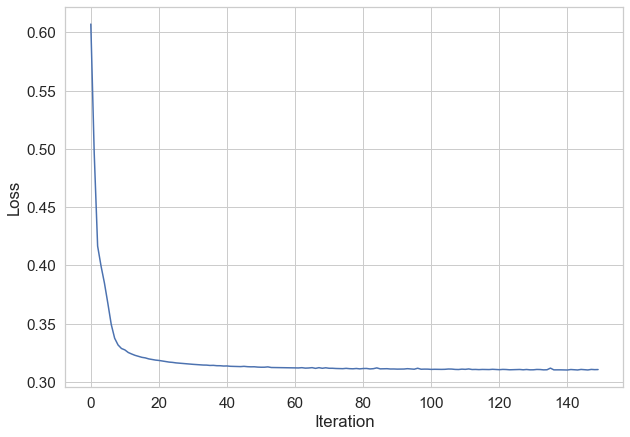

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(valid_loss_history)), valid_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

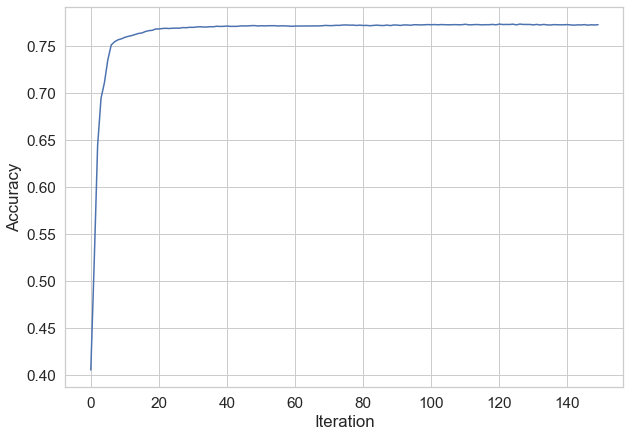

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(valid_accuracy_history)), valid_accuracy_history)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## Построим ROC_AUC кривую

In [49]:
y_test_pred = (rzd_net.forward(X_test_t).detach().numpy()) # > th).astype(int)
y_train_pred = (rzd_net.forward(X_train_t).detach().numpy()) # > th).astype(int)

In [50]:
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

In [51]:
fpr, tpr, th = roc_curve(y_train, y_train_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = argmax(gmeans)

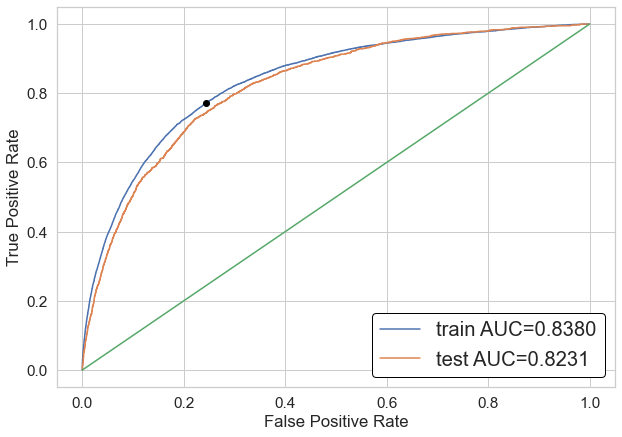

In [52]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Сравним по приколу с sklearn

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
mlp.fit(X_train, y_train)

In [ ]:
#clf.best_params_ {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam'}

In [ ]:
y_test_pred_MLP = mlp.predict_proba(X_test)[:,1]
y_train_pred_MLP = mlp.predict_proba(X_train)[:,1]

In [ ]:
y_test_pred.shape, y_test.shape, X_test.shape, y_test_pred_MLP.shape

In [ ]:
train_auc = roc_auc_score(y_train, y_train_pred_MLP)
test_auc = roc_auc_score(y_test, y_test_pred_MLP)
train_auc, test_auc

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_pred_MLP)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_pred_MLP)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Получили тоже самое. Это хорошо:)

## Covariate shift

In [ ]:
np_df = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values
np_labels = np.array(df.TARGET)

In [ ]:
blade = 92347 # Последние полгода

# Разобьем на трейн-тест выборку
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

In [ ]:
train = pd.DataFrame(X_train)
test = pd.DataFrame(X_test)

In [ ]:
test['is_train'] = 0
train['is_train'] = 1

In [ ]:
#объединение выборок train, test
df_combine = pd.concat([train, test], axis=0, ignore_index=True)

y = df_combine['is_train'].values #индикатор источника 
x = df_combine.drop('is_train', axis=1).values #объединенный датасет

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape)

In [ ]:
# Используем стратифицированное рандомизированное разбиение на 4 фолда. 
# Таким образом мы сохраним соотношение меток 'is_train' в каждом фолде, 
# как в исходной объединенной выборке. Для каждого разбиенения обучим 
# классификатор на большей части разбиения и предскажем метку класса для меньшей отложенной части.

from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
skf.split(x, y)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 
    rfc.fit(X_train, y_train)
    probs = rfc.predict_proba(X_test)[:, 1] #предсказание вероятностей классов
    predictions[test_idx] = probs

In [ ]:
print('ROC-AUC:', roc_auc_score(y_true=y, y_score=predictions))

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y, predictions)[:2], label='train AUC={:.4f}'.format(roc_auc_score(y, predictions)))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Как хорошо отделяем train от test')
plt.show()

Без one-hot энкодддинга и без признака MONTH_ORDERED: ROC_AUC = 0.8973

С ними: ROC_AUC = 0.9919

### Вывод:
Получается что One-hot энкоддинг + новый признак MONTH_ORDERED помогают не только увеличить скор, но также дают значительное улучшение при отделении train от test, что в принципе не удивительно.

## Теперь обучим на тех данных, которые похожи на test

In [ ]:
train.shape, test.shape, np_df.shape, y_train.shape

Снова разобьем на train test

In [ ]:
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

Делаем маску с объектами, которые больше похожи на тестовую выборку. 

In [ ]:
mask = rfc.predict_proba(X_train)[:,1] > 0.8
mask.shape

In [ ]:
X_similar = X_train[mask]
y_similar = y_train[mask]

In [ ]:
X_similar.shape, y_similar.shape

In [ ]:
mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
mlp.fit(X_similar, y_similar);

In [ ]:
y_test_pred = mlp.predict_proba(X_test)[:,1]
y_similar_pred = mlp.predict_proba(X_similar)[:,1]

In [ ]:
train_auc = roc_auc_score(y_similar, y_similar_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_similar, y_similar_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Получилось что-то совсем странное. Как будто отказы предсказывает хорошо, а НЕотказы плохо (или наоборот)

In [ ]:
y_test_pred = []
y_similar_pred = []

for i in np.arange(0.85, 0.95, 0.25):
    mask = rfc.predict_proba(X_train)[:,1] > i

    X_similar = X_train[mask]
    y_similar = y_train[mask]

    print(X_similar.shape, y_similar.shape)

    mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
    mlp.fit(X_similar, y_similar);

    y_test_pred.append(mlp.predict_proba(X_test)[:,1])
    y_similar_pred.append(mlp.predict_proba(X_similar)[:,1])

In [ ]:
y_similar_pred.shape()

fig, ax = plt.subplots(nrows=2, ncols=2)

for row in ax:
    for col in row:
        col.plot(*roc_curve(y_similar, y_similar_pred)[:2])
        col.plot(*roc_curve(y_test, y_test_pred)[:2])

plt.show()

In [ ]:
# Какой-то код

# Нормализация данных
# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)


# Класс на глаз
# n_hidden_neurons = 50
# rzd_net = torch.nn.Sequential(
#     torch.nn.Linear(X_train_t.shape[1], n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, 1),
#     torch.nn.Sigmoid()
# )

# fpr, tpr, thresholds = roc_curve(y_test, rzd_net.forward(X_test_t).detach().numpy())
# # get the best threshold
# J = tpr - fpr
# ix = argmax(J)
# best_thresh = thresholds[ix]
# print(f'Best Threshold={best_thresh}')
# print(f'Best roc_auc_score={roc_auc_score(y_test, (rzd_net.forward(X_test_t).detach().numpy() > 
# best_thresh).astype(int))}')


# import xgboost as xgb
# dtrain = xgb.DMatrix(x, y)
# params = {"objective": "binary:logistic", "max_depth": 6, "eta": 0.1, "min_child_weight": 10, 
#           "gamma": 0.75, "subsample": 0.8, "colsample_bytree": 0.95, "eval_metric": "auc"}
# num_rounds = 46
# xgb_model = xgb.train(params, dtrain, num_rounds)
# pred = xgb_model.predict(dtrain)